In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
import scipy.optimize as optimize
import scipy.signal
import json

In [3]:
# Load log
data = pd.read_csv('logs/G.txt', header=None, names=['t', 'c', 't1', 'x', 'y'])
display(data)

,t,c,t1,x,y
0,3.821354,M,2.255,0.521429,0.187755
1,3.821549,L,2.269,0.521429,0.186735
2,3.821595,L,2.275,0.520408,0.181633
3,3.821635,L,2.281,0.519388,0.180612
4,3.844561,L,2.306,0.513265,0.177551
...,...,...,...,...,...
100,5.538893,L,4.002,0.678571,0.685714
101,5.556287,L,4.019,0.736735,0.662245
102,5.586718,L,4.049,0.839796,0.610204
103,5.610213,L,4.073,0.904082,0.572449


In [4]:
# Split into strokes
stroke_starts = data[data['c'] == 'M'].index
stroke_ends = data[data['c'] == 'U'].index
strokes = [data[s:e + 1][['t1', 'x', 'y']].to_numpy() for s, e in zip(stroke_starts, stroke_ends)]
for stroke in strokes:
    stroke[:, 2] *= -1  # flip y-axis
for stroke in strokes:
    print(stroke.shape)

(105, 3)


/var/folders/6b/03yw1pts2nx_q8vftrh6fv140000gp/T/ipykernel_75102/3480592895.py:10: RuntimeWarning: divide by zero encountered in true_divide
  xdot = dx / dt


Text(0.5, 1.0, '||Acceleration|| vs time')

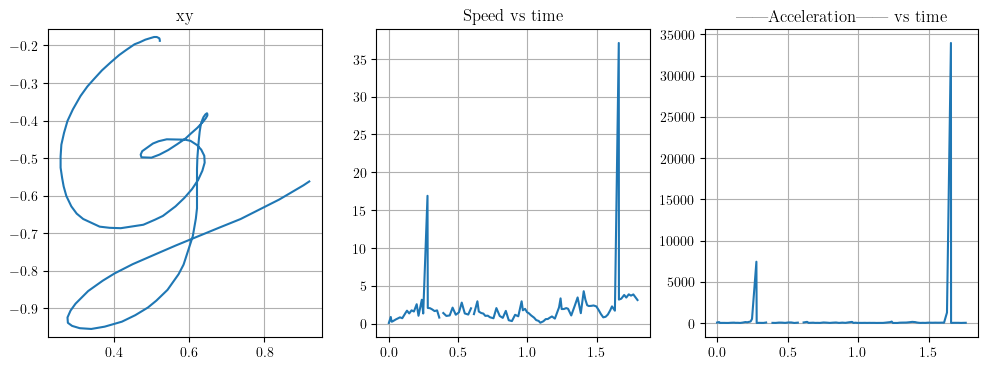

In [5]:
# Plot strokes
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for stroke in strokes:
    # Plot xy
    axes[0].plot(stroke[:, 1], stroke[:, 2])
    # Plot speed
    t = stroke[:, 0]
    dt = np.diff(t).reshape(-1, 1)
    dx = np.diff(stroke[:, 1:], axis=0)
    xdot = dx / dt
    axes[1].plot(t[:-1] - t[0], np.linalg.norm(xdot, axis=1))
    # Plot acceleration
    axes[2].plot(t[:-2] - t[0], np.linalg.norm(np.diff(xdot, axis=0) / dt[:-1], axis=1))
axes[0].axis('equal')
axes[0].set_title('xy')
axes[1].set_title('Speed vs time')
axes[2].set_title('||Acceleration|| vs time')


In [78]:
vmax = 1
amax = 5

def calc_derivatives(t, x):
    xdot = np.hstack(tuple(np.gradient(x[:, i], t).reshape(-1, 1) for i in range(2)))
    xddot = np.hstack(tuple(np.gradient(xdot[:, i], t).reshape(-1, 1) for i in range(2)))
    return xdot, xddot

# Extract raw trajectory
bad = np.diff(stroke[:, 0], axis=0) == 0
bad = np.hstack(([False], bad))
t = stroke[~bad, 0] - stroke[~bad, 0][0]
x = stroke[~bad, 1:]
xdot, xddot = calc_derivatives(t, x)

# TOPP-RA

In [79]:
import toppra as ta
from toppra.constraint import JointVelocityConstraint, JointAccelerationConstraint, DiscretizationType

# Setup path
if True: # include "bad" time points?
    t = stroke[:, 0] - stroke[0, 0]
    x = stroke[:, 1:]
    xdot, xddot = calc_derivatives(t, x)
path = ta.SplineInterpolator(scipy.signal.savgol_filter(t, 15, 3), x)

# Specify Constraints
vel_limits = np.ones((2, 1)) * vmax  # x and y
acc_limits = np.ones((2, 1)) * amax  # x and y
constr_vel = JointVelocityConstraint(np.hstack((-vel_limits, vel_limits)))
constr_acc = JointAccelerationConstraint(np.hstack((-acc_limits, acc_limits)),
                                         discretization_scheme=DiscretizationType.Interpolation)
# Setup parameterization instance
instance = ta.algorithm.TOPPRA([constr_vel, constr_acc], path, solver_wrapper='seidel')
jnt_traj = instance.compute_trajectory(sd_start=0, sd_end=0)

/Users/gerry/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:1215: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/gerry/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:1216: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/gerry/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:1217: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/gerry/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:1223: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/gerry/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:1239: RuntimeWarning: divide by zero encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


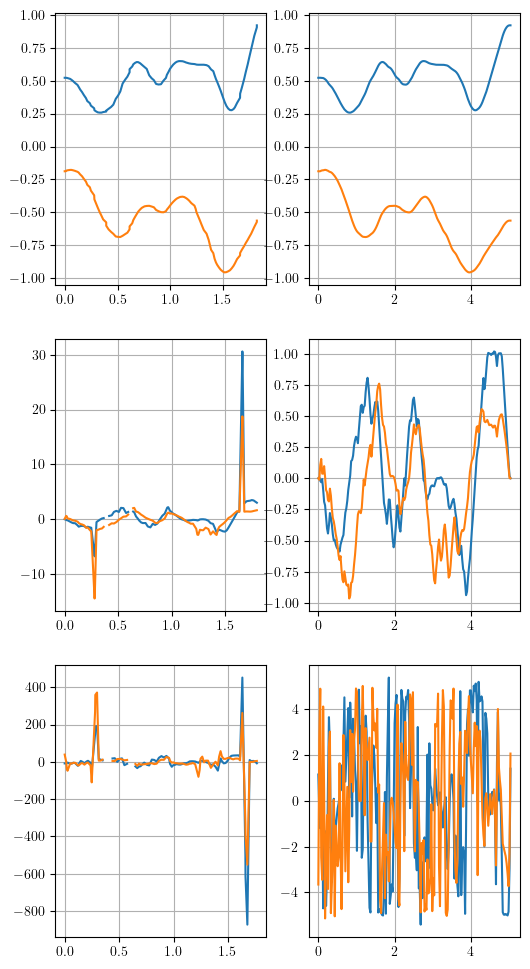

In [80]:
# Plot solution
fig, axes = plt.subplots(3, 2, figsize=(6, 12))
ts = np.linspace(0, jnt_traj.get_duration(), 200)
xs = jnt_traj.eval(ts)
xds = jnt_traj.evald(ts)
xdds = jnt_traj.evaldd(ts)

axes[0][0].plot(t, x, label=('x', 'y'))
axes[0][1].plot(ts, xs, label=('x', 'y'))
axes[1][0].plot(t, xdot, label=('x', 'y'))
axes[1][1].plot(ts, xds, label=('x', 'y'))
axes[2][0].plot(t, xddot, label=('x', 'y'))
axes[2][1].plot(ts, xdds, label=('x', 'y'))

In [81]:
data1 = np.hstack((t.reshape(-1, 1) - t[0], x))
data2 = np.hstack((ts.reshape(-1, 1), xs))
with open('test.html', 'w') as f:
    f.write('''
        <canvas id="c" width="600" height="300"></canvas>
        <a id="link"></a>
        <script>
            const canvas = document.getElementById('c');
            const ctx = canvas.getContext("2d");
            ctx.clearRect(0, 0, canvas.width, canvas.height);
            ctx.fillStyle = 'red';

            const data1 = ''' + json.dumps(data1.tolist()) + ''';
            const data2 = ''' + json.dumps(data2.tolist()) + ''';
            data1.forEach(element => {
            setTimeout(() => {
                console.log(element[1], element[2]);
                ctx.fillRect(element[1] * 300, -element[2] * 300, 5, 5);
            }, element[0] * 1000);
            });
            data2.forEach(element => {
            setTimeout(() => {
                console.log(element[1], element[2]);
                ctx.fillRect(element[1] * 300 + 300, -element[2] * 300, 5, 5);
            }, element[0] * 1000);
            });

            var link = document.getElementById('link');
            var c = 0;
            var running = true;
            setTimeout(() => { running = false; }, data2[data2.length - 1][0] * 1000);
            var intervalId = setInterval(function(){
                if (running) {
                    console.log('still running: ', running);
                    // page.render('temp/screenshot'+String(a).padStart(3,'0')+'.png');
                    link.setAttribute('download', 'screenshot'+String(c).padStart(3,'0')+'.png');
                    link.setAttribute('href', canvas.toDataURL("image/png").replace("image/png", "image/octet-stream"));
                    link.click();
                } else {
                    clearInterval(intervalId);
                    console.log('still running: ', running);
                    phantom.exit(0);
                };

                c++;
            }, 100);
        </script>
        ''')

## Math

Given a trajectory, speed, and acceleration:
$$x(t), |\dot{x}(t)|, |\ddot{x}(t)|$$
and a maximum speed and acceleration, $v_{max}, a_{max}$, we can ensure that the speed/acceleration are always within the bounds.

$x(t')$
$t'(t)$
\begin{align*}
|\dot{x}(t')| &= \left|\dot{x}(t)\frac{dt}{dt'}\right| \\
              &= \left|\dot{x}(t)\right|\frac{dt}{dt'} \\
              &\le v_{max} \\
|\ddot{x}(t')| &= \left|\frac{d}{dt'}\left(\dot{x}(t)\frac{dt}{dt'}\right)\right| \\
               &= \left|\ddot{x}(t)\frac{dt}{dt'}\frac{dt}{dt'} + \dot{x}(t)\frac{d^2t}{dt'^2}\right| \\
               &= \left|\ddot{x}(t)\left(\frac{dt}{dt'}\right)^2 + \dot{x}(t)\frac{d^2t}{dt'^2}\right| \\
               % &= \left|\dot{x}(t)\right| \left(\left(\frac{dt}{dt'}\right)^2 +\frac{d^2t}{dt'^2}\right) \\
               &\le a_{max}
\end{align*}

Solving for the a-scaling may be tricky:

\begin{align*}
y(t') &\coloneqq \frac{dt}{dt'} \\
a_{max} &= \left|  \ddot{x}y^2 + \dot{x} \dot{y}  \right|
\end{align*}

Maybe it's just easiest to make this an optimization problem

In [33]:
def rescale_for_v(t, x, vmax):
    dt = np.diff(t)
    xdot = np.diff(x, axis=0) / dt.reshape(-1, 1)
    dtprime_dt = np.linalg.norm(xdot, axis=1) / vmax
    tprime = np.hstack((0, np.cumsum(dtprime_dt * dt)))
    return tprime

tprime = rescale_for_v(t, x, vmax)
xdot_prime, xddot_prime = calc_derivatives(tprime, x)

In [34]:
def rescale_for_a(t, x, amax):
    xdot, xddot = calc_derivatives(t, x)
    def actual_a(y):
        ydot, _ = calc_derivatives(t, y) # NO!!! needs to be w.r.t. t'
        return xddot * np.square(y) + xdot * ydot
    loss = lambda y: a_max - actual_a(y)

(0.22479591836734691,
 0.9364285714285714,
 -0.9939795918367346,
 -0.13867346938775504)

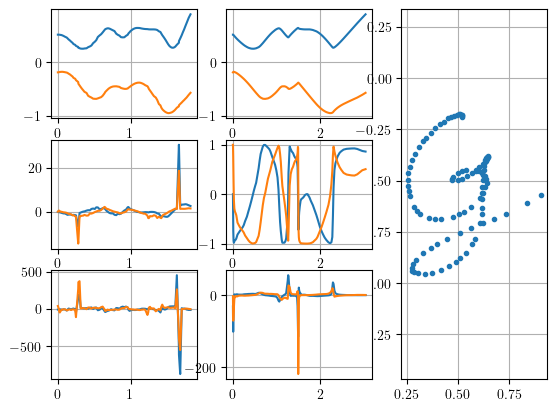

In [35]:
# Plot trajectories
fig, axes = plt.subplot_mosaic([
    ['x(t)', "x(t')", 'i'],
    ['v(t)', "v(t')", 'i'],
    ['a(t)', "a(t')", 'i'],
])
axes['x(t)'].plot(t, x)
axes['v(t)'].plot(t, xdot)
axes['a(t)'].plot(t, xddot)
axes["x(t')"].plot(tprime, x)
axes["v(t')"].plot(tprime, xdot_prime)
axes["a(t')"].plot(tprime, xddot_prime)
axes['i'].plot(*x.T, '.')
axes['i'].axis('equal')

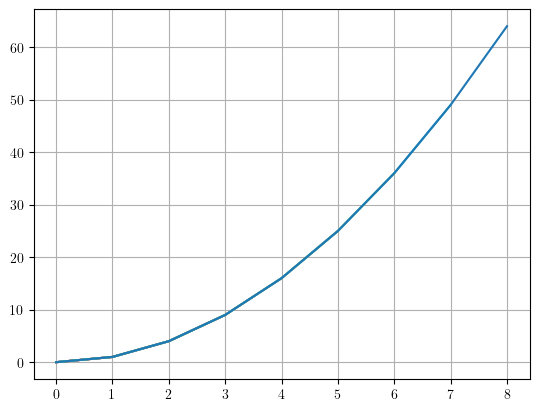

In [36]:
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
def p(i):
    ax.plot(range(i), np.arange(i) ** 2)
anim = FuncAnimation(fig, p, range(10))
HTML(anim.to_jshtml())

In [37]:
data1 = np.hstack((t.reshape(-1, 1) - t[0], x))
data2 = np.hstack((tprime.reshape(-1, 1), x))
with open('test.html', 'w') as f:
    f.write('''
        <canvas id="c" width="600" height="300"></canvas>
        <script>
            const canvas = document.getElementById('c');
            const ctx = canvas.getContext("2d");
            ctx.clearRect(0, 0, canvas.width, canvas.height);

            const data1 = ''' + json.dumps(data1.tolist()) + ''';
            const data2 = ''' + json.dumps(data2.tolist()) + ''';
            data1.forEach(element => {
            setTimeout(() => {
                console.log(element[1], element[2]);
                ctx.fillRect(element[1] * 300, -element[2] * 300, 5, 5);
            }, element[0] * 1000);
            });
            data2.forEach(element => {
            setTimeout(() => {
                console.log(element[1], element[2]);
                ctx.fillRect(element[1] * 300 + 300, -element[2] * 300, 5, 5);
            }, element[0] * 1000);
            });
        </script>
        ''')